# Pharmaceutical Name Generator

The project is simply based on FDA products names data. Given a prompt, the generator will autocomplete the word to generate the potential name of your pharmaceutical inspired by the training data used. The data can be found here:

https://www.fda.gov/drugs/drug-approvals-and-databases/drugsfda-data-files 

## Define and load the data

1. Import the data
2. Create a tokenizer
3. Char to index and Index to char dictionaries

In [98]:
with open('drug_names.txt', 'r') as f:
    data=f.read()

print(data[:100])

abacavir
abacavir and lamivudine
abaloparatide
abatacept
abciximab
abemaciclib
abiraterone
abobotuli


In [99]:
import tensorflow as tf

In [100]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~',
    split='\n',
)

tokenizer.fit_on_texts(data)

Here we create a dictionary of all the possible relevant characters from our training data. This will serve as a reference for text-understanding to our model 

In [101]:
char_to_index = tokenizer.word_index
index_to_char = dict((v,k) for k,v in char_to_index.items())  # Invert the token list so the integer/index values are the keys 
print(index_to_char)

{1: 'i', 2: 'a', 3: 'e', 4: 'o', 5: 'n', 6: 't', 7: 'l', 8: 'r', 9: 'c', 10: 'm', 11: ' ', 12: 'p', 13: 'd', 14: 's', 15: 'u', 16: 'b', 17: 'h', 18: 'f', 19: 'y', 20: 'g', 21: 'v', 22: 'z', 23: 'x', 24: 'k', 25: 'q', 26: 'w', 27: 'j', 28: '1', 29: '8', 30: '2', 31: '3', 32: '9', 33: "'", 34: '5', 35: '6', 36: '7', 37: '0', 38: '4'}


## Transformations between characters and index values

1. Converting between names and sequences will give a language that the model can use to understand the word patterns

In [102]:
names = data.splitlines()
names[:10]

['abacavir',
 'abacavir and lamivudine',
 'abaloparatide',
 'abatacept',
 'abciximab',
 'abemaciclib',
 'abiraterone',
 'abobotulinumtoxina',
 'abrocitinib',
 'acai']

Here is the thing. How will our machine learning algorithm understand the first pharmaceutical name (Avacabir)? It will use the tokens list we generated previously and deconstruct the word into integer values. See here an example and the function definition that will perform this:

In [103]:
def name_to_seq(name):
    return [tokenizer.texts_to_sequences(char)[0][0] for char in name]

name_to_seq(names[0]) # Example with the word "Abacavir"

[2, 16, 2, 9, 2, 21, 1, 8]

We need to be able to also do the opposite action, and transform integer-sequences into words:

In [104]:
def seq_to_name(seq):
    return ''.join([index_to_char[i] for i in seq if i!=0])

seq_to_name(name_to_seq(names[0]))  # Example

'abacavir'

## Generate patterns to feed for the model

1. Creating sequences
2. Padding all sequences

In [105]:
sequences = []

for name in names:
    print(name)
    seq = name_to_seq(name)
    if len(seq) >= 2:
        sequences += [seq[:i] for i in range(2, len(seq)+1)]

abacavir
abacavir and lamivudine
abaloparatide
abatacept
abciximab
abemaciclib
abiraterone
abobotulinumtoxina
abrocitinib
acai
acalabrutinib
acamprosate
acarbose
acebutolol
acetaminophen
acetaminophen and aspirin
acetaminophen butalbital caffeine codeine
acetaminophen chlorpheniramine
acetaminophen chlorpheniramine dextromethorphan
acetaminophen chlorpheniramine phenylephrine
acetaminophen dextromethorphan phenylephrine
acetaminophen dextromethorphan pseudoephedrine
acetaminophen diphenhydramine dextromethorphan
acetaminophen iv
acetaminophen pamabrom pyridoxine
acetaminophen phenyltoloxamine
acetaminophen rectal
acetazolamide
acetic acid otic
acetohydroxamic acid
acetylcholine
acetylcysteine
acitretin
aclidinium
aconite
activated charcoal
acyclovir
acyclovir and hydrocortisone topical
acyclovir ophthalmic
acyclovir topical
adagrasib
adalimumab
adapalene
adapalene and benzoyl peroxide topical
adapalene topical
adefovir
adenosine
aducanumab
afamelanotide
afatinib
aflibercept intravitrea

In [106]:
print(sequences[:10])

max_len = max([len(x) for x in sequences])
print(max_len)

[[2, 16], [2, 16, 2], [2, 16, 2, 9], [2, 16, 2, 9, 2], [2, 16, 2, 9, 2, 21], [2, 16, 2, 9, 2, 21, 1], [2, 16, 2, 9, 2, 21, 1, 8], [2, 16], [2, 16, 2], [2, 16, 2, 9]]
62


There is no index 0 as you may have noticed. 0 is gonna be our filler (pre-padding) for sequences that are shorter than the word with most letters. By this way we have a way to operate with all of them. Checked here the example with the first two letters of "":

In [107]:
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    sequences, padding="pre",
    maxlen=max_len
)
print(padded_sequences[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  2 16]


## Creating Training and Validation Sets

1. Let's create treaning and validation sets that our model can use

In [108]:
x,y = padded_sequences[:, :-1], padded_sequences[:,-1]
print(x.shape, y.shape)

(26845, 61) (26845,)


In [109]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y)

In [110]:
num_chars = len(char_to_index.keys())+1
print(num_chars)

39


## Model definition

We need to create a Recurrent Neural Network that can train with our padded_sequences:

In [111]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPool1D, LSTM    # LSTM: Long Short-term memory network
from tensorflow.keras.layers import Bidirectional, Dense  

model = Sequential([
    Embedding(num_chars, 8, input_length=max_len-1), # Embedding layer, typical in any NLP task (acts as a lookup table for the LSTM)
    Conv1D(64, 5, strides=1, activation="tanh", padding='causal'), # 64 filters, kernel size is 5 and strides 1. Causal padding (paddles are temporal depedendant by their shared word)
    MaxPool1D(2),
    LSTM(32),
    Dense(num_chars, activation='softmax')  # Softmax activation for the classification task
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 61, 8)             312       
                                                                 
 conv1d_1 (Conv1D)           (None, 61, 64)            2624      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 30, 64)            0         
 g1D)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 39)                1287      
                                                                 
Total params: 16639 (65.00 KB)
Trainable params: 16639 (65.00 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

## Training the Model

In [130]:
h = model.fit(
    x_train, y_train,
    validation_data = (x_test, y_test),
    epochs=30, verbose=2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
    ]
)

Epoch 1/30
630/630 - 5s - loss: 2.0692 - accuracy: 0.3827 - val_loss: 2.4858 - val_accuracy: 0.2922 - 5s/epoch - 8ms/step
Epoch 2/30
630/630 - 5s - loss: 2.0627 - accuracy: 0.3880 - val_loss: 2.4898 - val_accuracy: 0.2963 - 5s/epoch - 8ms/step
Epoch 3/30
630/630 - 5s - loss: 2.0560 - accuracy: 0.3875 - val_loss: 2.4942 - val_accuracy: 0.2938 - 5s/epoch - 7ms/step
Epoch 4/30
630/630 - 5s - loss: 2.0500 - accuracy: 0.3888 - val_loss: 2.4893 - val_accuracy: 0.2972 - 5s/epoch - 7ms/step
Epoch 5/30
630/630 - 5s - loss: 2.0436 - accuracy: 0.3909 - val_loss: 2.4906 - val_accuracy: 0.2965 - 5s/epoch - 7ms/step
Epoch 6/30
630/630 - 5s - loss: 2.0366 - accuracy: 0.3915 - val_loss: 2.5058 - val_accuracy: 0.2957 - 5s/epoch - 7ms/step
Epoch 7/30
630/630 - 5s - loss: 2.0308 - accuracy: 0.3945 - val_loss: 2.4907 - val_accuracy: 0.2963 - 5s/epoch - 7ms/step


Lets represent the validation and training accuracy to check that the model did not overfit the data!

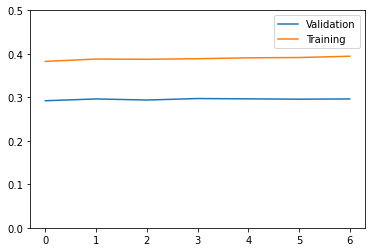

In [131]:
from matplotlib import pyplot as plt
epochs_ran = len(h.history['loss'])

plt.plot(range(0, epochs_ran), h.history['val_accuracy'], label='Validation')
plt.plot(range(0, epochs_ran), h.history['accuracy'], label='Training')
plt.ylim([0,0.5])

plt.legend()
plt.show()

## Generate Pharmaceutical Names!

In [126]:
def generate_names(seed):
    for i in range(0, 20):
        seq = name_to_seq(seed)
        padded = tf.keras.preprocessing.sequence.pad_sequences([seq], padding='pre', maxlen=(max_len-1), truncating='pre')
        
        pred = model.predict(padded)[0]
        pred_char = index_to_char[tf.argmax(pred).numpy()]
        seed += pred_char 
    
        if pred_char == '\t' or pred_char == ' ':
            break
    print(seed)

In [128]:
# Here is an example of a name that will be generated just with my initials (GRA)
generate_names('gra')

1/1 [==============================] - 0s 16ms/step
graneranoreii 
